# FINAL PROJECT

Link to the Google Colab  https://colab.research.google.com/drive/1vH8MOkvJKeHEhwX6MhdUW082OTD5D_Ho?usp=sharing


In this project we will use *Kaggle environments*, in particular this one [ConnectX](https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/connectx/connectx.ipynb).






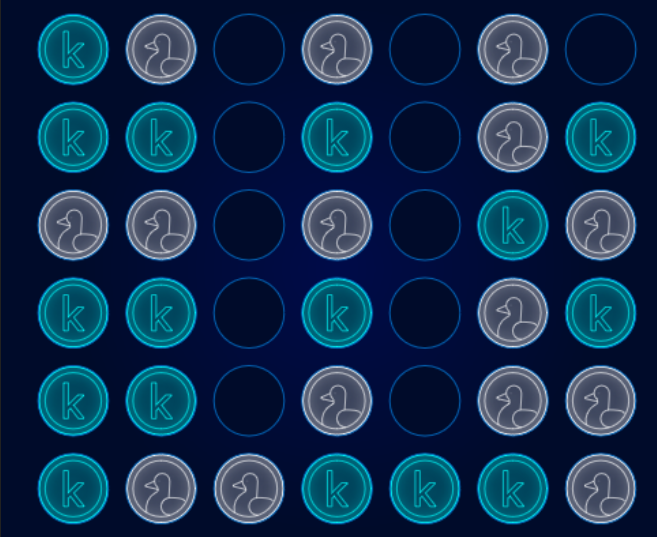

In there, the objective is to create an agent that can play, learn from experience and eventually win (at least against a random player).

## Deliverables:
  1. Your version of this notebook, where you create your agents. You can create as many as you want (from all the algorithms we studied this term), indicating which ones you choose to be tested.

  Alternatively, you might want to submit `python` files for each (class of) agent.
  
  **PGT students** at least have to create 2 agents, where one of them has to be Sarsa($\lambda$).
  
  

  2. After training your agents, you might want to save those learnt values. This can be a dictionary with the `optimal policy`, or `Q-values`. If an approximate method was used, you can provide the `final weights`, etc.

  3. A short report (no more than 10 pages), where you explain your methodology, chosen algorithms, visualisations of the learning process (how rewards increase over time, or how loss functions decrease).

  You should indicate clearly in the report which agents  of all the ones you created, you want to be tested (at most two). You should also explain **why** you chose them.

## Evaluation


Your projects will be evaluated primarily on the development of the agents, not necessarily in their performance. Being said that, better performance will lead in general to better marks.

For example one marking criteria could be to to assign a `70%` to the deliverables pointed out above (where your agents have to run properly, not necessarily win), and the remaining `30%` for performance tests (how good are your agents). In there I will be testing how your agents perform against the two default agents from the environment: `random, negamax`, as well as how they perform against each other, and against a human player.

Final criteria will depend on the overall submissions.

The first line of code install all the `kaggle environments`. If you want to install them locally (and not use Colab), it is the same line if you are using `Jupyter notebooks`.

There are certain advantages to such local installation: for example, training can be faster if you have a reasonable computer. Also, training against a `human player`, only works on local installations. There are of course advantages of using Colab instead (no need to install anything, you can use the lab computers...).

In [3]:
!pip install kaggle-environments --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.1/134.1 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


We import the necessary libraries. (run the following cell twice).

In [4]:
from kaggle_environments import make, evaluate

# Create the game environment
# Set debug=True to see the errors if your agent refuses to run
env = make("connectx", debug=True)

# List of available default agents
print(list(env.agents))

['random', 'negamax']


## Parameters
To make the training a bit easier (less time consuming) we will work on the case of a grid of `4x5` in which you aim to place `3` consecutive pieces (vertical, horizontal or diagonal).

In [5]:
rows = 4
columns = 5
in_a_row = 3
debug_mode = True


env = make("connectx", {"rows": rows, "columns": columns, "inarow": in_a_row}, steps=[], debug=debug_mode)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
import joblib
from kaggle_environments import make

# **My agent 1: Q-Learning**
---

In [7]:
class QLearningAgent:
    def __init__(self, rows, columns, in_a_row, alpha=1, epsilon=1, gamma=1, num_episodes=10000):
        self.rows = rows
        self.columns = columns
        self.in_a_row = in_a_row
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.nA = columns  # Number of possible actions
        self.nS = rows * columns  # Number of possible states
        self.Q = defaultdict(self.init_Q_values)  # Initialize empty dictionary to store Q-values
        self.state_key = None  # Current state
        self.next_state_key = None  # Next state

    # Function to initialize Q-values
    def init_Q_values(self):
        return np.zeros(self.nA)

    def act(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.nA)
        else:
            state_key = tuple(observation.board)
            return np.argmax(self.Q[state_key])

    def learn(self, observation, action, reward, next_observation):
        if reward is None or not isinstance(reward, (int, float)):
            reward = 0

        self.state_key = tuple(observation.board)
        self.next_state_key = tuple(next_observation.board)
        td_target = reward + self.gamma * np.max(self.Q[self.next_state_key])
        td_error = td_target - self.Q[self.state_key][action]
        self.Q[self.state_key][action] += self.alpha * td_error


In [8]:
def train_agent(env, agent, num_episodes, save_path=None):
    wins = 0
    invalid = 0

    for _ in tqdm(range(num_episodes)):
        obs = env.reset()
        done = False
        while not done:
            action = agent.act(obs)
            new_obs, reward, done, info = env.step(action)
            agent.learn(obs, action, reward, new_obs)
            obs = new_obs

        if done:
            obs = env.reset()
            if reward == 1:
                wins += 1
            if reward != 1 and reward != -1:
                invalid += 1

    win_percentage = (wins / (num_episodes - invalid)) * 100
    print("Percentage of games won:", win_percentage)

    # Save the agent if a save path is provided
    if save_path:
        joblib.dump(agent, save_path)
        print("Learning saved at:", save_path)

In [9]:
# Create the Q-Learning agent
my_agent1 = QLearningAgent(rows, columns, in_a_row)


trainer1 = env.train([None, "random"]) # Set up the environment trainer

train_agent(trainer1, my_agent1, num_episodes=100, save_path='q_learning_agent1.pkl') # Train the agent using Q-Learning


  0%|          | 0/100 [00:00<?, ?it/s]

Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 4
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Percentage of games won: 68.96551724137932
Learning saved at: q_learning_agent1.pkl


In [10]:
def trained_policy(observation, agent):
    return agent.act(observation)

Let's try it out:

In [11]:
obs = env.reset()  # Get the initial observation
action = trained_policy(obs, my_agent1)

# Define a wrapper function for trained_policy that links to the specific agent
def call_agent_1(observation, configuration):
    return trained_policy(observation, my_agent1)

# Run a game with the trained policy against a random opponent
env.run([call_agent_1, 'random'])
env.render(mode="ipython")  # Show the game

# Print the reward obtained during the game
print(env.state[0].reward)


1


In [15]:
trainer2 = env.train([None, "negamax"])

train_agent(trainer2, my_agent1, num_episodes=100, save_path='q_learning_agent2.pkl')


  0%|          | 0/100 [00:00<?, ?it/s]

Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 4
Invalid Action: Invalid column: 3
Percentage of games won: 7.216494845360824
Learning saved at: q_learning_agent2.pkl


In [19]:
obs = env.reset()  # Get the initial observation
action2 = trained_policy(obs, my_agent1)

# Define a wrapper function for trained_policy that links to the specific agent
def trained_policy_wrapper(observation, configuration):
    return trained_policy(observation, my_agent1)

# Run a game with the trained policy against a random opponent
env.run([trained_policy_wrapper, 'random'])
env.render(mode="ipython")  # Display the game

# Print the reward obtained during the game
print(env.state[0].reward)

1


It's very bad against negamax


# **My agent 2: Sarsa(λ)**

---



In [20]:
class SarsaLambdaAgent:
    def __init__(self, rows, columns, in_a_row, epsilon=0.5, alpha=0.1, gamma=0.9, lmbda=0.5):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.lmbda = lmbda
        self.columns = columns
        self.weights = np.random.rand(rows * columns)  # Initialize weights with appropriate length
        self.eligibility_trace = np.zeros(rows * columns)  # Initialize eligibility trace

    def act(self, obs):
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.columns))  # Return random move
        else:
            valid_moves = [col for col in range(self.columns) if obs.board[col] == 0]
            state_features = np.array(obs.board)
            action_values = np.dot(self.weights, state_features)
            if np.isscalar(action_values):  # Handle scalar case
                return valid_moves[0]  # Return the first valid move
            else:
                return int(valid_moves[np.argmax(action_values[valid_moves])])  # Convert action to integer

    def learn(self, obs, action, reward, next_obs):
        if reward is None:
            reward = 0  # Set reward to 0 if it's None
        state_key = tuple(obs.board)
        next_state_key = tuple(next_obs.board)
        td_error = reward + self.gamma * np.dot(self.weights, next_obs.board) - np.dot(self.weights, obs.board)
        self.eligibility_trace = self.gamma * self.lmbda * self.eligibility_trace + obs.board
        self.weights += self.alpha * td_error * self.eligibility_trace
        self.epsilon *= 0.6  # Decay epsilon


In [21]:
def train_SarsaLambda_agent(env, agent, num_episodes, load_path=None, save_path=None):
    if load_path:
        agent.weights = np.load(load_path)
    wins = 0
    total_rewards = np.zeros(num_episodes)
    invalid = 0

    for iEpisode in tqdm(range(num_episodes), position=0, leave=True):
        obs = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = agent.act(obs)
            new_obs, reward, done, _ = env.step(action)

            if reward is None:
                # The action was invalid, no reward
                invalid += 1
                break

            agent.learn(obs, action, reward, new_obs)
            episode_reward += reward
            obs = new_obs

        total_rewards[iEpisode] = episode_reward

        if episode_reward == 1:
            wins += 1

    win_percentage = (wins / (num_episodes - invalid)) * 100
    print("Percentage of games won:", win_percentage)

    # Save the agent if a save path is provided
    if save_path:
        np.save(save_path, agent.weights)
        print("Learning saved at:", save_path)

    return total_rewards


In [22]:
# Create the Q-Learning agent
my_agent2 = SarsaLambdaAgent(rows, columns, in_a_row)

trainer1 = env.train([None, "random"])

train_SarsaLambda_agent(trainer1, my_agent2, num_episodes=100, save_path='SarsaLambdaAgent')


  0%|          | 0/100 [00:00<?, ?it/s]

Invalid Action: 1 is not of type 'integer'

Failed validating 'type' in schema:
    {'default': 0,
     'description': 'Column to drop a checker onto the board.',
     'minimum': 0,
     'type': 'integer'}

On instance:
    1
Invalid Action: 2 is not of type 'integer'

Failed validating 'type' in schema:
    {'default': 0,
     'description': 'Column to drop a checker onto the board.',
     'minimum': 0,
     'type': 'integer'}

On instance:
    2
Percentage of games won: 75.51020408163265
Learning saved at: SarsaLambdaAgent


array([ 0.,  0.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,
        1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.])

In [23]:
# Define a function for the agent to play against the ConnectX environment
def call_agent_2(observation, configuration):
    return my_agent2.act(observation)

# Run a game with the trained agent against a random opponent
env.run([call_agent_2, "random"])

# Display the game
env.render(mode="ipython")

# Print the reward obtained during the game
print("Game reward:", env.state[0].reward)


Game reward: 1


que pasa si random empieza primero

In [24]:
# Define a function for the agent to play against the ConnectX environment
def call_agent_2(observation, configuration):
    return my_agent2.act(observation)

# Run a game with the trained agent against a random opponent
env.run(["random", call_agent_2])

# Display the game
env.render(mode="ipython")

# Print the reward obtained during the game
print("Game reward:", env.state[0].reward)


Game reward: 1


Train it against randomax.

In [25]:
# Crear el agente Q-Learning
my_agent2 = SarsaLambdaAgent(rows, columns, in_a_row)


trainer12 = env.train([None, "negamax"])

train_SarsaLambda_agent(trainer12, my_agent2, num_episodes=100, load_path='SarsaLambdaAgent.npy',  save_path='SarsaLambdaAgent_negamax')


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of games won: 0.0
Learning saved at: SarsaLambdaAgent_negamax


array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [26]:
#Run a game with the trained agent against a negamax opponent

env.run(["negamax", call_agent_2])
#Display the game

env.render(mode="ipython")
print("Game reward:", env.state[0].reward)

Game reward: 1


In [30]:
#Run a game with agent1 vs agent2

env.run([call_agent_1, call_agent_2])
#Display the game

env.render(mode="ipython")
print("Game reward:", env.state[0].reward)

Game reward: 1


In [31]:
num_games = 10
wins_agent_1 = 0
wins_agent_2 = 0

for _ in range(num_games):
    env.reset()  # Reset the environment for each game

    # Run the game with agents 1 and 2
    env.run([call_agent_1, call_agent_2])

    # Calculate the game reward and determine the winner
    reward = env.state[0].reward
    if reward == 1:
        wins_agent_1 += 1
    elif reward == -1:
        wins_agent_2 += 1

# Calculate the win percentages
win_percentage_agent_1 = (wins_agent_1 / num_games) * 100
win_percentage_agent_2 = (wins_agent_2 / num_games) * 100

# Display the results
print("Number of games:", num_games)
print("Wins of agent 1:", wins_agent_1, "(", win_percentage_agent_1, "%)")
print("Wins of agent 2:", wins_agent_2, "(", win_percentage_agent_2, "%)")

Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Number of games: 10
Wins of agent 1: 1 ( 10.0 %)
Wins of agent 2: 7 ( 70.0 %)


In [32]:
num_games = 100
wins_agent_1 = 0
wins_agent_2 = 0

for _ in range(num_games):
    env.reset()  # Reset the environment for each game

    # Run the game with agents 1 and 2
    env.run([call_agent_1, call_agent_2])

    # Calculate the game reward and determine the winner
    reward = env.state[0].reward
    if reward == 1:
        wins_agent_1 += 1
    elif reward == -1:
        wins_agent_2 += 1

# Calculate the win percentages
win_percentage_agent_1 = (wins_agent_1 / num_games) * 100
win_percentage_agent_2 = (wins_agent_2 / num_games) * 100

# Display the results
print("Number of games:", num_games)
print("Wins of agent 1:", wins_agent_1, "(", win_percentage_agent_1, "%)")
print("Wins of agent 2:", wins_agent_2, "(", win_percentage_agent_2, "%)")

Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Number of games: 100
Wins of agent 1: 33 ( 33.0 %)
Wins of agent 2: 46 ( 46.0 %)


In [33]:
num_games = 1000
wins_agent_1 = 0
wins_agent_2 = 0

for _ in range(num_games):
    env.reset()  # Reset the environment for each game

    # Run the game with agents 1 and 2
    env.run([call_agent_1, call_agent_2])

    # Calculate the game reward and determine the winner
    reward = env.state[0].reward
    if reward == 1:
        wins_agent_1 += 1
    elif reward == -1:
        wins_agent_2 += 1

# Calculate the win percentages
win_percentage_agent_1 = (wins_agent_1 / num_games) * 100
win_percentage_agent_2 = (wins_agent_2 / num_games) * 100

# Display the results
print("Number of games:", num_games)
print("Wins of agent 1:", wins_agent_1, "(", win_percentage_agent_1, "%)")
print("Wins of agent 2:", wins_agent_2, "(", win_percentage_agent_2, "%)")

Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action

Last agent but I won't use it.

# **My agent 3: REINFORCE-with-Baseline: Monte-Carlo Policy Gradient**



---



In [34]:

class ReinforceWithBaselineAgent:
    def __init__(self, observation_space, action_space, gamma=0.99, alpha_w=0.001, alpha_theta=0.001):
        self.observation_space = observation_space
        self.action_space = action_space
        self.gamma = gamma
        self.alpha_w = alpha_w
        self.alpha_theta = alpha_theta
        self.w = np.random.rand(observation_space.shape[0])  # Weights for the state-value function
        self.theta = np.random.rand(observation_space.shape[0], action_space.n)  # Weights for the policy
        self.grad_theta = np.zeros_like(self.theta)  # Gradient of policy weights
        self.grad_w = np.zeros_like(self.w)  # Gradient of state-value weights

    def act(self, observation):
        logits = np.dot(observation, self.theta)
        probs = np.exp(logits) / np.sum(np.exp(logits))
        action = np.random.choice(self.action_space.n, p=probs)
        return action

    def learn(self, episode):
        states, actions, rewards = zip(*episode)
        T = len(states)
        G = 0
        for t in range(T - 1, -1, -1):
            G = self.gamma * G + rewards[t]
            state = states[t]
            action = actions[t]
            baseline = np.dot(state, self.w)
            pi = np.exp(np.dot(state, self.theta)) / np.sum(np.exp(np.dot(state, self.theta)))
            grad_ln_pi = np.zeros_like(self.theta)
            grad_ln_pi[:, action] = state / pi[action]
            self.grad_theta += self.gamma**t * (G - baseline) * grad_ln_pi
            self.grad_w += self.gamma**t * (G - baseline) * state
        self.theta += self.alpha_theta * self.grad_theta / T
        self.w += self.alpha_w * self.grad_w / T
        self.grad_theta = np.zeros_like(self.theta)
        self.grad_w = np.zeros_like(self.w)

In [35]:
def train_reinforce_baseline(env, agent, num_episodes):
    total_rewards = []
    for _ in tqdm(range(num_episodes)):
        episode = []
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.act(obs)
            new_obs, reward, done, _ = env.step(action)
            episode.append((obs, action, reward))
            obs = new_obs
            total_reward += reward
        agent.learn(episode)
        total_rewards.append(total_reward)
    return total_rewards